# Photometric redshift estimation ([László Dobos](https://github.com/dobos))

## Sloan Digital Sky Survey

The Sloan Digital Sky Survey (sometimes also called the Cosmic Genome Project) is a systematic photographic and specroscopic mapping of the extragalactic universe. During the first phase of the project, an imaging survey was conducted to photograph the sky in five optical wavelength band with a 120 megapixel camera. It was followed by a spectroscopic survey where more than 2 million objects, including more than a million galaxies were observed with a multi-fiber spectrograph.

The SDSS catalog (numerical parameters of the detected objects extracted from the multi-band images) is available as a relational database via SkyServer.

* Link to SDSS SkyServer: http://skyserver.sdss.org/

## Magnitudes

The logaritm of flux ratios is called the color index. It is easy to see that the color index is the difference of to magnitudes measured in the corresponding filters:

$$ CI_{AB} = m_A - m_B. $$

An interesting property of the color index -- when neglecting K-correction -- is that it does not depend on the distance, since the distance moduli cancel out.

## Photometric redshift estimation

The theoretically motivated method uses spectrum templates to fit galaxy colors. In this process, we start with a template set which covers most galaxy spectral types. We try each template and gradually increase its redshift in small steps. At each small redshift step we calculate the _synthetic magnitude_ of the template in through each filter curve's transmission function. This way the best fit redshift and galaxy type can be determined and the method also allows for finding the galaxy's spectral type.

Empirical methods, on the other hand, start with a _training set_ instead of theoretical template spectra. A training set consits of galaxies with both known color indices and spectroscopic redshifts. Then we apply various types of machine learning algorithms (polynomial fitting, local linear regression, kNN, random forest or even deep learning) to learn correlations from the training set and apply it to the large unknown ensemble of photometry-only galaxies. This method relies heavily on the quality of the training set. The training set should cover the entire redshift and color range of the photometric sample, which condition is rarely satisfied as the photometric sample is deeper (i.e. contains fainter galaxies). Empirical methods can be used for extrapolation but the validity of the extrapolated redshifts is hard to verify without additional spectroscopic follow-up observations.

* Link to Csabai et al. (2002) paper: http://adsabs.harvard.edu/abs/2000AJ....119...69C
* Link to the Beck et al. (2016) paper: http://adsabs.harvard.edu/abs/2016MNRAS.460.1371B
* Link to Beck et al. (2016) web site: http://www.vo.elte.hu/papers/2016/photoz/

## Tasks

### 1. Data aquisition

Register to SDSS SkyServer and collect the necessary data from the SDSS DR7 main galaxy sample. Preferably use the database to compute the absolute magnitudes. You will need the `PhotoObj` table to get the magnitudes `modelMag_*` and foreground extinction values `extinction_*`. Filter the data set to contain galaxies only. The best-suited property to do the filtering is `probPSF` which gives the probability of an object being a point source instead of a resolved source. A low-redshift spectroscopic training set can be constructed by joining on the `SpecObj` table which contains the redshift in column `z`. Joins have to be made on the `PhotoObj.objID = SpecObj.bestObjID` foreign key. For a higher redshift training set, download the data file of Beck et al. (2016).
   * I completed this by registering to the SkyServer website and using the [CasJobs tool](http://skyserver.sdss.org/CasJobs/SubmitJob.aspx). Via this I was able to acquire different sized data sets for testing porpuses.
   
   * The data acquired contains 5% error at most in the petro and in the model magnitudes as well and the points correspond to galaxies.
   
   * I only used the DR7 database which contains ~750 000 points like those mentioned above.

### 2. Empirical methods

After evaluating the acquired data set, split the training set in half and try several machine learning methods from scikit learn to estimate the photometric redshift of the training set. Split the training set in half for testing purposes. Try the kNN, SVM and random forest estimators. Compare the methods by drawing appropriate plots and evaluate the behavior of errors.
   * I implemented a naive KNN algorith which makes a prediction of redshift based on the **k** nearest neighbors' redshifts. It gets the mean of it and returns the prediction. Algorithms such as multiclass SVM, KNN, and Random Forest are implemented from the *[skLearn](http://scikit-learn.org/stable/)* python package.
   
   * N section cross-validation is implemented for all the algorithms and their speed is measured as well. The algorithms are general enough to run them on different labels of the dataset so I am not required to use color indeces but instead I could use petro magnitudes without extinction or any combination of labels as well.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations as comb

In [16]:
dataset = pd.read_csv("SDSSDR7-5-percent-err-limit-10000-line.csv")
print(dataset.columns.values)

['m_u' 'm_g' 'm_r' 'm_i' 'm_z' 'pm_u' 'pm_g' 'pm_r' 'pm_i' 'pm_z' 'ext_u'
 'ext_g' 'ext_r' 'ext_i' 'ext_z' 'ug' 'gr' 'ri' 'iz' 'p_ug' 'p_gr' 'p_ri'
 'p_iz' 'z']


In [17]:
# Creating training and test sets from data
mask = np.random.rand(len(dataset)) < 0.2 # make the test set more then 20% of the dataset
# Convert masked data to np array
train = dataset[mask]
test = dataset[~mask]

In [18]:
model_mags = ['m_u','m_g','m_r','m_i','m_z']
model_color_indices = ['ug', 'gr', 'ri', 'iz']
petro_color_indices = ['p_ug','p_gr','p_ri','p_iz']
print(train[model_color_indices].shape, test[model_color_indices].shape)

(1985, 4) (8015, 4)


In [19]:
def plot_galaxies_by_color_indices(data, labels, name='Default.png'):
    # 6 for all the possible parings
    plt.figure(figsize=(15,10))
    batch = 1
    for ind, subset in enumerate(comb(labels, 2)):
        subplt = plt.subplot(int("23%d" % (ind + 1)))
        subplt.scatter(data[subset[0]].values[::batch], data[subset[1]].values[::batch],
                       marker='.')
        subplt.set_title("Scatter plot for %s - %s" % (subset[0], subset[1]))
        subplt.set_xlabel("%s" % subset[0])
        subplt.set_ylabel("%s" % subset[1])
    plt.savefig(name)

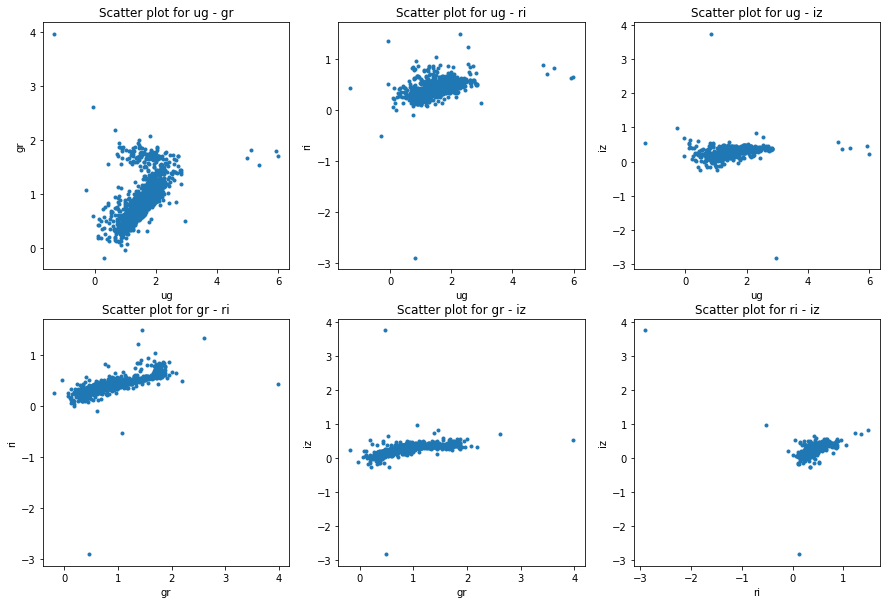

In [20]:
plot_galaxies_by_color_indices(train, model_color_indices)

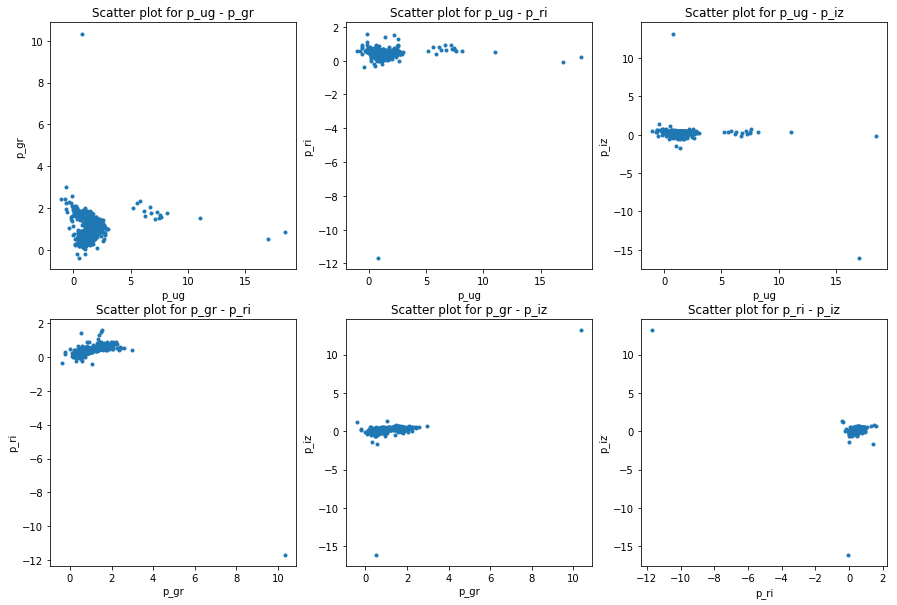

In [21]:
plot_galaxies_by_color_indices(train, petro_color_indices)

In [22]:
from sklearn.neighbors import NearestNeighbors
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

def naive_knn(test, train, labels, k=13):
    prediction = []
    batch = 1 # too slow so I must batch
    for point in test[labels].values:
        dists = [np.sqrt(np.sum(np.square(point - train_point))) for train_point in train[labels].values[::batch]]
        ind = np.argpartition(dists, k) # k smallest indices
        prediction.append(np.mean(train['z'].values[::batch][ind][:k])) # append the mean of the k smallest distance values
    return np.array(prediction)

def sklearn_knn(test, train, labels, k=13):
    prediction = []
    neigh = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
    neigh.fit(train[labels].values)
    for point in test[labels].values:
        indices = neigh.kneighbors([point], return_distance=False)[0,:]
        prediction.append(np.mean(train['z'].values[indices]))
    return np.array(prediction)

def sklearn_svm(test, train, labels, k=7):
    prediction = []
    batch = 1
    max_redshift = np.max(train['z'].values)
    min_redshift = np.min(train['z'].values)
    classifier = svm.SVR()
    n_bins = k*10 if k*10 < 100 else 100
    edges = np.histogram(train['z'].values[::batch], bins=n_bins, range=(min_redshift, max_redshift))[1]
    edges_with_overflow = np.histogram(train['z'].values[::batch], bins=n_bins+1, range=(min_redshift, max_redshift))[1]
    classifier.fit(train[labels].values[::batch], edges_with_overflow[np.digitize(train['z'].values[::batch], edges)])
    for point in test[labels].values:
        prediction.append(classifier.predict([point])[0])
    return np.array(prediction)


def sklearn_random_forest(test, train, labels, k=7):
    prediction = []
    batch = 1
    max_redshift = np.max(train['z'].values)
    min_redshift = np.min(train['z'].values)
    n_bins = k*10 if k*10 < 100 else 100
    classifier = RandomForestRegressor(n_estimators=n_bins, max_depth=6, random_state=6)
    edges = np.histogram(train['z'].values[::batch], bins=n_bins, range=(min_redshift, max_redshift))[1]
    edges_with_overflow = np.histogram(train['z'].values[::batch], bins=n_bins+1, range=(min_redshift, max_redshift))[1]
    classifier.fit(train[labels].values[::batch], edges_with_overflow[np.digitize(train['z'].values[::batch], edges)])
    for point in test[labels].values:
        prediction.append(classifier.predict([point])[0])
    return np.array(prediction)

In [23]:
pred1 = naive_knn(test, train, model_color_indices)
pred2 = sklearn_knn(test, train, model_color_indices)
pred3 = sklearn_svm(test, train, model_color_indices)
pred4 = sklearn_random_forest(test, train, model_color_indices)

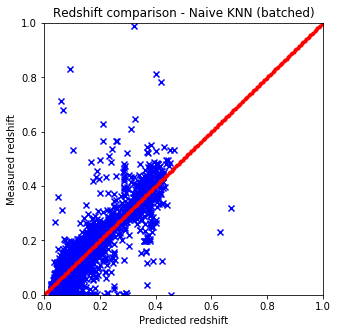

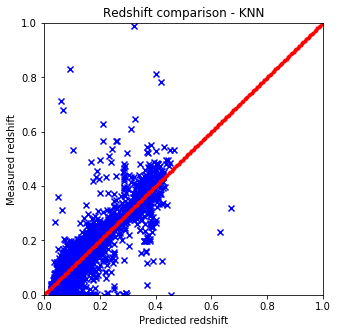

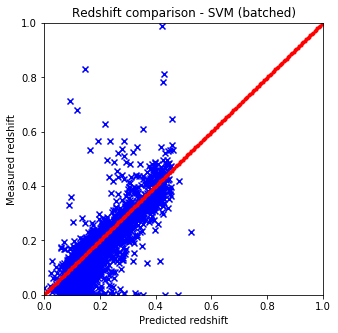

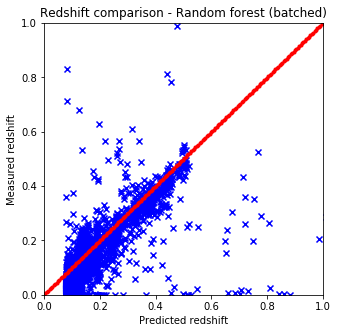

In [24]:
def plot_predictions(pred, test, title):
    plt.figure(figsize=(5.,5.))
    plt.xlim(0,1)
    plt.ylim(0,1)
    line = np.linspace(0, 1, num=200)
    plt.scatter(pred, test['z'].values, c='b', marker='x')
    plt.scatter(line, line, c='r', marker='.')
    plt.xlabel('Predicted redshift')
    plt.ylabel('Measured redshift')
    plt.title('Redshift comparison - %s' % title)
    plt.show()

plot_predictions(pred1, test, "Naive KNN (batched)") # batched
plot_predictions(pred2, test, "KNN")
plot_predictions(pred3, test, "SVM (batched)") # batched
plot_predictions(pred4, test, "Random forest (batched)") # batched

In [25]:
import time
from sklearn.model_selection import train_test_split

def cross_validate(algo, dataset, labels, splits=5, k=10):
    MAEs = []
    MSEs = []
    start = time.time()
    for i in range(splits):
        train, test = train_test_split(dataset,
                            test_size=(1.-1./splits),
                            random_state=42*(k-i)+i*137)
        y_test = test['z'].values
        y_pred = algo(test, train, labels, k)
        MAEs.append(np.sum(np.absolute(y_pred-y_test))/y_test.shape[0])
        MSEs.append(np.sum(np.square(y_pred-y_test))/y_test.shape[0])
    print("Mean MAE : %.5f" % np.mean(MAEs))
    print("\tStandard deviation of MAE : %.5f" % np.std(MAEs))
    print("Mean MSE : %.5f" % np.mean(MSEs))
    print("\tStandard deviation of MSE : %.5f" % np.std(MSEs))
    end = time.time()
    print("The operation took %.2f seconds.\n\n" % (end-start))

In [26]:
print("Random forest:\n*******************************")
cross_validate(sklearn_random_forest, dataset, model_color_indices, splits=5, k=7)

print("Support vector machine:\n**********************")
cross_validate(sklearn_svm, dataset, model_color_indices, splits=5, k=7)

print("K-nearest neighbors:\n*************************")
cross_validate(sklearn_knn, dataset, model_color_indices, splits=5, k=7)

print("Naive K-nearest neighbors:\n*******************")
cross_validate(naive_knn, dataset, model_color_indices, splits=5, k=7)

Random forest:
*******************************
Mean MAE : 0.04056
	Standard deviation of MAE : 0.00602
Mean MSE : 0.00787
	Standard deviation of MSE : 0.00067
The operation took 241.73 seconds.


Support vector machine:
**********************
Mean MAE : 0.04052
	Standard deviation of MAE : 0.00530
Mean MSE : 0.00631
	Standard deviation of MSE : 0.00083
The operation took 3.06 seconds.


K-nearest neighbors:
*************************
Mean MAE : 0.02438
	Standard deviation of MAE : 0.00035
Mean MSE : 0.00517
	Standard deviation of MSE : 0.00110
The operation took 19.48 seconds.


Naive K-nearest neighbors:
*******************
Mean MAE : 0.02438
	Standard deviation of MAE : 0.00035
Mean MSE : 0.00517
	Standard deviation of MSE : 0.00110
The operation took 1137.49 seconds.




In [27]:
print("Random forest:\n****************************")
cross_validate(sklearn_random_forest, dataset, petro_color_indices, splits=5, k=7)

print("Support vector machine:\n*******************")
cross_validate(sklearn_svm, dataset, petro_color_indices, splits=5, k=7)

print("K-nearest neighbors:\n**********************")
cross_validate(sklearn_knn, dataset, petro_color_indices, splits=5, k=7)

print("Naive K-nearest neighbors\n*****************")
cross_validate(naive_knn, dataset, petro_color_indices, splits=5, k=7)

Random forest:
****************************
Mean MAE : 0.04277
	Standard deviation of MAE : 0.00557
Mean MSE : 0.00711
	Standard deviation of MSE : 0.00031
The operation took 150.19 seconds.


Support vector machine:
*******************
Mean MAE : 0.04644
	Standard deviation of MAE : 0.00543
Mean MSE : 0.00701
	Standard deviation of MSE : 0.00078
The operation took 2.45 seconds.


K-nearest neighbors:
**********************
Mean MAE : 0.02919
	Standard deviation of MAE : 0.00022
Mean MSE : 0.00570
	Standard deviation of MSE : 0.00113
The operation took 11.64 seconds.


Naive K-nearest neighbors
*****************
Mean MAE : 0.02919
	Standard deviation of MAE : 0.00022
Mean MSE : 0.00570
	Standard deviation of MSE : 0.00113
The operation took 2391.83 seconds.




### Results
* Naive and sklearn implementations give the same results. The only drawback which is huge that the naive implementation is way slower than the one from sci-kit. 
* The *batch* variable included in the predictor functions are for this reason only since with larger datasets the run time gets huge.
* The best options to cluster the data seems to be **KNN from skLearn** which is not at all suprising considering the nature of the data.